# California Housing EDA and Modeling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [3]:
from pathlib import Path
DATA_PATH = Path("data/housing.csv")
df = pd.read_csv(DATA_PATH)
df.describe()
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

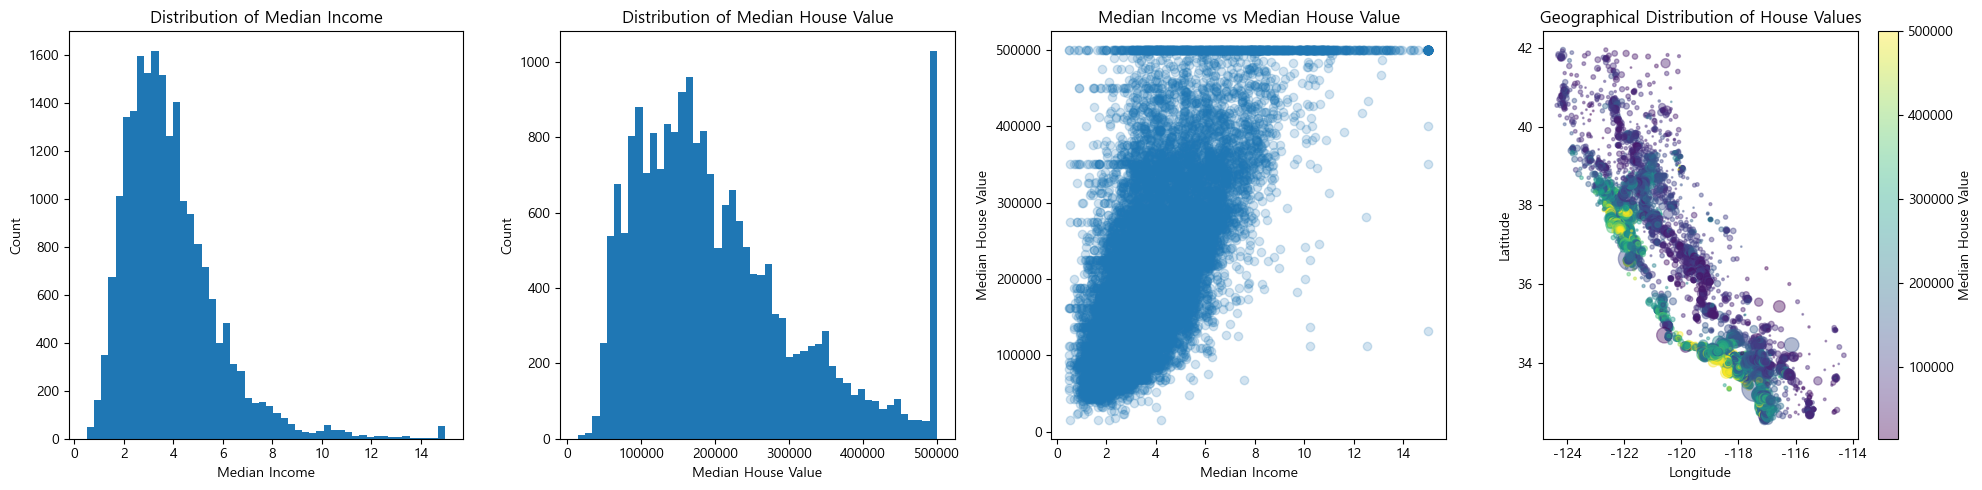

In [4]:
corr = df.corr(numeric_only=True)
target_corr = corr["median_house_value"].sort_values(ascending=False)

# 시각화
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

## 중위 소득 분포
axes[0].hist(df["median_income"], bins=50)
axes[0].set_title("Distribution of Median Income")
axes[0].set_xlabel("Median Income")
axes[0].set_ylabel("Count")

## 중위 주택 가치 분포
axes[1].hist(df["median_house_value"], bins=50)
axes[1].set_title("Distribution of Median House Value")
axes[1].set_xlabel("Median House Value")
axes[1].set_ylabel("Count")

## 중위 소득 vs 중위 주택 가치
axes[2].scatter(df["median_income"], df["median_house_value"], alpha=0.2)
axes[2].set_title("Median Income vs Median House Value")
axes[2].set_xlabel("Median Income")
axes[2].set_ylabel("Median House Value")

## 지리적 분포 (주택 가치)
sc = axes[3].scatter(df["longitude"], df["latitude"], c=df["median_house_value"],
                     s=(df["population"]/100).clip(lower=1), alpha=0.4)
axes[3].set_title("Geographical Distribution of House Values")
axes[3].set_xlabel("Longitude")
axes[3].set_ylabel("Latitude")

# 컬러바 추가
cbar = plt.colorbar(sc, ax=axes[3])
cbar.set_label("Median House Value")

plt.tight_layout()
plt.show()

In [5]:
X = df.drop("median_house_value", axis=1)
y = df["median_house_value"]

num_features = X.select_dtypes(include=["float64", "int64", "float32", "int32"]).columns.tolist()
cat_features = ["ocean_proximity"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
imputer = SimpleImputer(strategy="median")
X_train_num = imputer.fit_transform(X_train[num_features])
X_test_num = imputer.transform(X_test[num_features])

scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

encoder = OneHotEncoder(handle_unknown="ignore")
X_train_cat = encoder.fit_transform(X_train[cat_features]).toarray()
X_test_cat = encoder.transform(X_test[cat_features]).toarray()

X_train_processed = np.hstack([X_train_num_scaled, X_train_cat])
X_test_processed = np.hstack([X_test_num_scaled, X_test_cat])

In [7]:
results = []

def evaluate_model(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"{name}:")
    print(f"-- R^2 Score: {r2:.4f}")
    print(f"-- RMSE: {rmse:.2f}")
    return {"model": name, "r2": r2, "rmse": rmse}

In [8]:
# Linear Regression (기본)
lr_model = LinearRegression()
lr_model.fit(X_train_processed, y_train)
y_pred_lr = lr_model.predict(X_test_processed)

result_lr = evaluate_model("Linear Regression", y_test, y_pred_lr)
results.append(result_lr)

# Linear Regression (PolynomialFeatures)
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
X_train_num_poly = poly.fit_transform(X_train_num_scaled)
X_test_num_poly = poly.transform(X_test_num_scaled)

X_train_poly_combined = np.hstack([X_train_num_poly, X_train_cat])
X_test_poly_combined = np.hstack([X_test_num_poly, X_test_cat])

poly_lr_model = LinearRegression()
poly_lr_model.fit(X_train_poly_combined, y_train)
y_pred_poly_lr = poly_lr_model.predict(X_test_poly_combined)

result_poly_lr = evaluate_model("Polynomial + Linear Regression", y_test, y_pred_poly_lr)
results.append(result_poly_lr)

# Ridge (PolynomialFeatures)
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train_poly_combined, y_train)
y_pred_ridge = ridge_model.predict(X_test_poly_combined)

result_ridge = evaluate_model("Ridge Regression (Polynomial)", y_test, y_pred_ridge)
results.append(result_ridge)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train_processed, y_train)
y_pred_rf = rf_model.predict(X_test_processed)

result_rf = evaluate_model("Random Forest", y_test, y_pred_rf)
results.append(result_rf)

Linear Regression:
-- R^2 Score: 0.6254
-- RMSE: 70059.19
Polynomial + Linear Regression:
-- R^2 Score: 0.6570
-- RMSE: 67043.55
Ridge Regression (Polynomial):
-- R^2 Score: 0.6562
-- RMSE: 67117.25
Random Forest:
-- R^2 Score: 0.8170
-- RMSE: 48975.66


In [9]:
results_df = pd.DataFrame(results)
num_names = num_features
cat_names = list(encoder.get_feature_names_out(cat_features))
all_feature_names = num_names + cat_names
importances = rf_model.feature_importances_
fi = pd.DataFrame({
    "feature": all_feature_names, 
    "importance": importances
}).sort_values("importance", ascending=False)
fi

,feature,importance
7,median_income,0.490709
9,ocean_proximity_INLAND,0.142093
0,longitude,0.106885
1,latitude,0.100868
2,housing_median_age,0.052342
5,population,0.032319
3,total_rooms,0.023741
4,total_bedrooms,0.022672
6,households,0.017196
12,ocean_proximity_NEAR OCEAN,0.006752


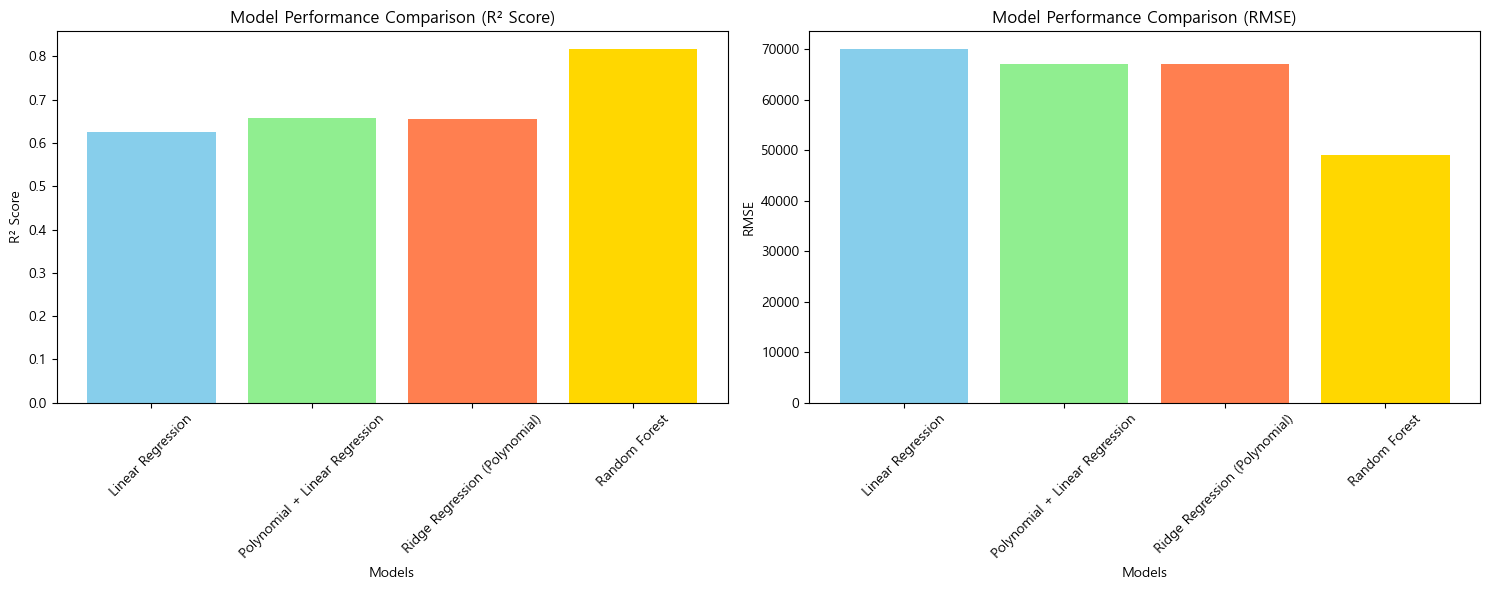

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# R² Score 비교
models = results_df['model']
r2_scores = results_df['r2']
ax1.bar(range(len(models)), r2_scores, color=['skyblue', 'lightgreen', 'coral', 'gold'])
ax1.set_xlabel('Models')
ax1.set_ylabel('R² Score')
ax1.set_title('Model Performance Comparison (R² Score)')
ax1.set_xticks(range(len(models)))
ax1.set_xticklabels(models, rotation=45)

# RMSE 비교
rmse_scores = results_df['rmse']
ax2.bar(range(len(models)), rmse_scores, color=['skyblue', 'lightgreen', 'coral', 'gold'])
ax2.set_xlabel('Models')
ax2.set_ylabel('RMSE')
ax2.set_title('Model Performance Comparison (RMSE)')
ax2.set_xticks(range(len(models)))
ax2.set_xticklabels(models, rotation=45)

plt.tight_layout()
plt.show()

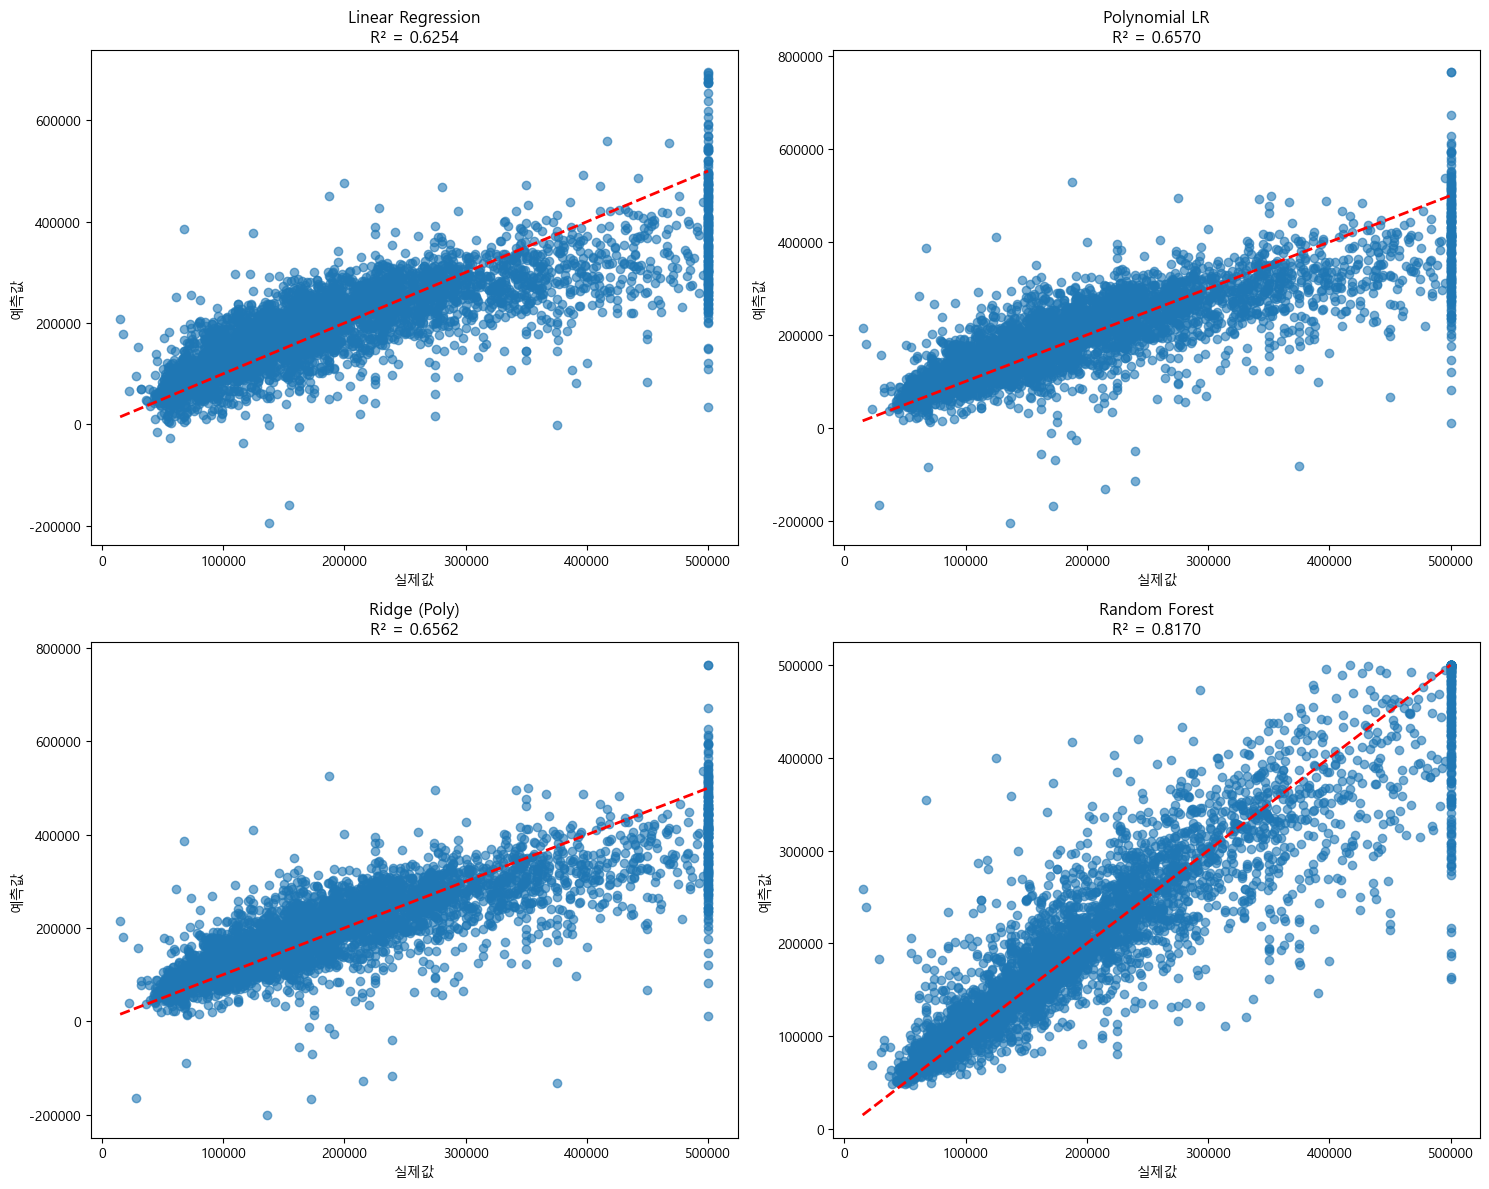

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
predictions = [y_pred_lr, y_pred_poly_lr, y_pred_ridge, y_pred_rf]
model_names = ['Linear Regression', 'Polynomial LR', 'Ridge (Poly)', 'Random Forest']

for i, (ax, pred, name) in enumerate(zip(axes.flatten(), predictions, model_names)):
    ax.scatter(y_test, pred, alpha=0.6)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    ax.set_xlabel('실제값')
    ax.set_ylabel('예측값')
    ax.set_title(f'{name}\nR² = {results[i]["r2"]:.4f}')
    
plt.tight_layout()
plt.show()

개선방안
1. 전처리를 다시

2. 지표를 추가하기   +   올바른 평가인가?
    =>R2, RMSE          => K-폴드 라는 평가방법 도입(ch05)
    + 분위, 내가 만든 지표(만들기 어려움)

1-2. 올바른 평가인지 확인이 된다면 모델을 개선